# 🎨 Deteksi Warna Real-Time dengan YOLOv8 dan Dataset KaggleHub (Perbaikan V2)

Selamat datang di notebook ini! Kami akan melakukan deteksi warna menggunakan YOLOv8 dengan dataset dari KaggleHub. Notebook ini telah diperbaiki untuk mengatasi masalah `No images found` dengan mengatur struktur dataset yang benar.

In [ ]:
# ✅ 1. Install Library
# Instalasi library yang dibutuhkan: ultralytics, opencv-python, dan kagglehub.
!pip install ultralytics opencv-python kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
# 2. Import Library
import kagglehub
import os
import shutil
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow # Khusus untuk menampilkan gambar di Google Colab
from sklearn.model_selection import train_test_split
import glob

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# 📥 3. Download Dataset dari KaggleHub
# Unduh dataset warna dari KaggleHub dan pindahkan ke lokasi yang diinginkan.

print("Mengunduh dataset dari KaggleHub...")
downloaded_path = kagglehub.dataset_download("adikurniawan/color-dataset-for-color-recognition")
print(f"Dataset berhasil diunduh ke: {downloaded_path}")

# Tentukan jalur tujuan untuk dataset yang diekstrak
base_dataset_path = "/content/image/"

# Hapus direktori tujuan jika sudah ada untuk menghindari konflik
if os.path.exists(base_dataset_path):
    print(f"Menghapus direktori yang sudah ada: {base_dataset_path}")
    shutil.rmtree(base_dataset_path)

# Buat direktori tujuan
os.makedirs(base_dataset_path, exist_ok=True)

# Salin isi dataset yang diunduh ke jalur tujuan
print("Menyalin dataset ke direktori kerja...")
for item in os.listdir(downloaded_path):
    source = os.path.join(downloaded_path, item)
    destination = os.path.join(base_dataset_path, item)
    if os.path.isdir(source):
        shutil.copytree(source, destination)
    else:
        shutil.copy2(source, destination)

# Path dataset root yang akan kita gunakan untuk training
dataset_root = os.path.join(base_dataset_path, 'yolov8_dataset') # Nama folder baru untuk struktur YOLOv8
print(f"Dataset berhasil disalin ke: {base_dataset_path}")

Mengunduh dataset dari KaggleHub...
Dataset berhasil diunduh ke: /kaggle/input/color-dataset-for-color-recognition
Menyalin dataset ke direktori kerja...
Dataset berhasil disalin ke: /content/image/


In [ ]:
# 4. Mengatur Ulang Struktur Dataset Sesuai Kebutuhan YOLOv8
# Dataset asli memiliki gambar per folder warna. Kita perlu mengaturnya ulang ke dalam folder images/train, images/val dan labels/train, labels/val.

print("Mulai mengatur ulang struktur dataset...")

# Definisikan direktori training_dataset asli yang berisi folder warna
original_training_dataset_path = os.path.join(base_dataset_path, 'training_dataset')

# Buat struktur folder yang diharapkan oleh YOLOv8
os.makedirs(os.path.join(dataset_root, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(dataset_root, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(dataset_root, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(dataset_root, 'labels', 'val'), exist_ok=True)

print(f"Struktur folder YOLOv8 dibuat di: {dataset_root}")

# Definisikan kelas-kelas warna (harus sama dengan di data.yaml)
classes = ['black','blue','brown','green','grey','orange','red','violet', 'white', 'yellow']
class_to_id = {name: i for i, name in enumerate(classes)}

all_image_paths = []

# Kumpulkan semua path gambar dan buat label dummy
for color_folder in os.listdir(original_training_dataset_path):
    if os.path.isdir(os.path.join(original_training_dataset_path, color_folder)) and color_folder in classes: # Pastikan itu folder warna yang valid
        current_color_path = os.path.join(original_training_dataset_path, color_folder)
        images_in_folder = glob.glob(os.path.join(current_color_path, '*.jpg')) + \
                           glob.glob(os.path.join(current_color_path, '*.jpeg')) + \
                           glob.glob(os.path.join(current_color_path, '*.png'))

        for img_path in images_in_folder:
            all_image_paths.append(img_path)

if not all_image_paths:
    raise ValueError("Tidak ada gambar ditemukan di subfolder warna yang diharapkan. Pastikan dataset telah diunduh dan diekstrak dengan benar.")

# Bagi dataset menjadi training dan validation set
train_images, val_images = train_test_split(all_image_paths, test_size=0.2, random_state=42)

print(f"Total gambar ditemukan: {len(all_image_paths)}")
print(f"Gambar training: {len(train_images)}")
print(f"Gambar validasi: {len(val_images)}")

# Fungsi untuk membuat dan menyalin gambar/label
def copy_and_create_labels(image_list, target_images_dir, target_labels_dir):
    for img_src_path in image_list:
        img_filename = os.path.basename(img_src_path)

        # Tentukan nama kelas dari nama folder (e.g., 'red' dari '/content/image/training_dataset/red/red1.jpg')
        color_name = os.path.basename(os.path.dirname(img_src_path))
        class_id = class_to_id[color_name]

        # Salin gambar
        shutil.copy(img_src_path, os.path.join(target_images_dir, img_filename))

        # Buat file label YOLO (.txt)
        label_filename = os.path.splitext(img_filename)[0] + '.txt'
        label_path = os.path.join(target_labels_dir, label_filename)

        # Untuk dataset ini, setiap gambar hanya memiliki satu objek di tengah
        # Jika objek tidak selalu di tengah atau ukurannya bervariasi, ini perlu disesuaikan
        # Format YOLO: class_id center_x center_y width height (normalized)
        # Karena gambar adalah objek tunggal di tengah, kita bisa asumsikan 0.5 0.5 1.0 1.0
        with open(label_path, 'w') as f:
            f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

# Salin gambar dan buat label untuk set training
print("Menyalin gambar dan membuat label untuk training set...")
copy_and_create_labels(train_images, os.path.join(dataset_root, 'images', 'train'), os.path.join(dataset_root, 'labels', 'train'))

# Salin gambar dan buat label untuk set validasi
print("Menyalin gambar dan membuat label untuk validation set...")
copy_and_create_labels(val_images, os.path.join(dataset_root, 'images', 'val'), os.path.join(dataset_root, 'labels', 'val'))

print("Pengaturan ulang dataset selesai!")

Mulai mengatur ulang struktur dataset...
Struktur folder YOLOv8 dibuat di: /content/image/yolov8_dataset
Total gambar ditemukan: 249
Gambar training: 199
Gambar validasi: 50
Menyalin gambar dan membuat label untuk training set...
Menyalin gambar dan membuat label untuk validation set...
Pengaturan ulang dataset selesai!


In [ ]:
# 5. Siapkan File data.yaml
# File data.yaml mendefinisikan jalur ke data training dan validasi, serta daftar kelas.

data_yaml = f"""
path: {dataset_root} # Menggunakan path root yang baru
train: images/train
val: images/val
nc: 10
names: ['black','blue','brown','green','grey','orange','red','violet', 'white', 'yellow']
"""

with open(f"{dataset_root}/data.yaml", "w") as f:
    f.write(data_yaml)
print(f"File data.yaml berhasil dibuat di: {dataset_root}/data.yaml")

File data.yaml berhasil dibuat di: /content/image/yolov8_dataset/data.yaml


In [ ]:
# 6. Verifikasi Isi Direktori Dataset yang Baru (Opsional)
print(f"Isi dari {dataset_root}/images/train:")
print(os.listdir(os.path.join(dataset_root, 'images', 'train'))[:5]) # Tampilkan 5 file pertama
print(f"Isi dari {dataset_root}/labels/train:")
print(os.listdir(os.path.join(dataset_root, 'labels', 'train'))[:5]) # Tampilkan 5 file pertama

print(f"Isi dari {dataset_root}/images/val:")
print(os.listdir(os.path.join(dataset_root, 'images', 'val'))[:5]) # Tampilkan 5 file pertama
print(f"Isi dari {dataset_root}/labels/val:")
print(os.listdir(os.path.join(dataset_root, 'labels', 'val'))[:5]) # Tampilkan 5 file pertama

Isi dari /content/image/yolov8_dataset/images/train:
['9f8170.png', '803790.png', 'yellow10.png', '41fdfe.png', 'c0c6c9.png']
Isi dari /content/image/yolov8_dataset/labels/train:
['black14.txt', 'black11.txt', 'ffa000.txt', 'yellow2.txt', 'b69e87.txt']
Isi dari /content/image/yolov8_dataset/images/val:
['568203.png', 'a8a9a8.png', 'ertiga.png', 'grey22.png', '9896a4.png']
Isi dari /content/image/yolov8_dataset/labels/val:
['1ac1dd.txt', '9c51b6.txt', 'd9dfe0.txt', 'a8a9a8.txt', 'cdccd0.txt']


In [33]:
# 🧠 7. Latih Model dengan YOLOv8
# Mulai proses training model YOLOv8. Kami menggunakan model 'yolov8n.pt' (nano) sebagai model pre-trained.
# epoch: Jumlah iterasi training.
# imgsz: Ukuran gambar input.

print("Memulai training model YOLOv8...")
model = YOLO("yolov8m.pt")
results = model.train(data=f"{dataset_root}/data.yaml", epochs=100, imgsz=640) # Menggunakan dataset_root yang baru
print("Training selesai!")

Memulai training model YOLOv8...


100%|██████████| 49.7M/49.7M [00:00<00:00, 427MB/s]


Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/image/yolov8_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

train: Scanning /content/image/yolov8_dataset/labels/train.cache... 199 images, 0 backgrounds, 0 corrupt: 100%|██████████| 199/199 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 13.9±14.4 MB/s, size: 0.5 KB)


val: Scanning /content/image/yolov8_dataset/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       6.2G     0.7167      3.763      1.306         17        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         50         50      0.276      0.655      0.219      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.33G     0.2518      2.166      1.026         17        640: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         50         50      0.487      0.516      0.514      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.37G     0.2079      1.713     0.9802         20        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         50         50      0.329      0.628      0.454      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.33G     0.2229      1.564     0.9702         23        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         50         50       0.16      0.381      0.211      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       6.4G     0.2217      1.274     0.9596         21        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         50         50       0.32      0.643      0.493      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       6.4G     0.2473      1.352     0.9773         23        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         50         50      0.425      0.533      0.398      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.32G     0.2522      1.217     0.9803         22        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         50         50      0.315       0.38      0.424      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.39G     0.2541      1.137     0.9677         25        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         50         50      0.402      0.588      0.532      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.31G     0.2228      1.134      0.951         23        640: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         50         50      0.385      0.627      0.469      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.41G     0.2228      1.206     0.9478         26        640: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         50         50      0.427      0.716      0.588      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.41G     0.1959      1.116     0.9417         23        640: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         50         50      0.663      0.492      0.516      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.39G     0.1867      1.044     0.9286         20        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         50         50      0.364      0.794      0.422      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.31G     0.2229      1.022      0.972         21        640: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         50         50      0.568      0.605       0.62      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.41G     0.2556      0.984     0.9642         26        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         50         50      0.478       0.82      0.736      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.39G     0.2187     0.9064     0.9577         21        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         50         50      0.634      0.916      0.863      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.39G     0.2188     0.9913     0.9556         20        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         50         50      0.814      0.683      0.791      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.31G     0.2135      1.015     0.9441         20        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         50         50      0.817      0.809      0.853      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       6.4G     0.2134     0.9222     0.9546         19        640: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         50         50      0.538      0.862      0.821       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.41G     0.1938      0.858     0.9428         20        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         50         50      0.624      0.796      0.795      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       6.4G     0.2157      0.905     0.9545         19        640: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         50         50      0.916      0.628      0.757      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.31G     0.2054     0.9711     0.9389         24        640: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         50         50      0.801      0.942      0.971      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       6.4G     0.1819     0.9412     0.9286         19        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         50         50      0.777      0.874      0.943      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       6.4G     0.1866     0.8057     0.9495         19        640: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         50         50      0.814      0.846      0.833      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       6.4G     0.1897      1.022     0.9282         19        640: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         50         50      0.707      0.854      0.872      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.32G     0.1768     0.8698     0.9243         21        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         50         50      0.734      0.883       0.84      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       6.4G     0.1818      0.845     0.9449         27        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         50         50      0.827      0.864      0.915      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       6.4G     0.1595     0.7718     0.9168         23        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         50         50      0.794      0.876      0.918      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       6.4G     0.1581     0.8116     0.9262         26        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         50         50      0.948      0.924      0.984      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.31G     0.1598     0.8647     0.9165         22        640: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         50         50        0.8      0.936      0.914      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       6.4G       0.17     0.7655     0.9353         20        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         50         50      0.757      0.957      0.973      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.41G     0.1595     0.7217      0.925         24        640: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         50         50      0.809      0.917      0.958      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.39G     0.1561     0.6776     0.8985         22        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         50         50      0.737      0.917      0.939      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.31G     0.1682     0.7906     0.9153         24        640: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         50         50      0.645      0.946      0.935      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       6.4G     0.1529     0.7662     0.9162         22        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         50         50      0.653      0.871       0.83      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.39G     0.1464     0.7075     0.9153         22        640: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         50         50      0.695      0.961      0.895      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.39G     0.1473     0.7716     0.9207         22        640: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         50         50      0.729      0.879      0.867      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.32G     0.1467     0.7766     0.9241         23        640: 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         50         50      0.894      0.812      0.908      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.41G     0.1326     0.7794     0.8995         21        640: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         50         50      0.739      0.861      0.916       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       6.4G     0.1477     0.7458     0.9276         25        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         50         50      0.766      0.866      0.895      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.39G     0.1352     0.7088     0.9272         23        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         50         50      0.839      0.981      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.32G     0.1419     0.7747     0.9344         20        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         50         50      0.804      0.894      0.919      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.41G     0.1336     0.7387     0.9217         19        640: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         50         50      0.729      0.876      0.911      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       6.4G     0.1233     0.6819     0.9061         24        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         50         50      0.703      0.897      0.874      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       6.4G     0.1247     0.6166     0.9045         24        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         50         50      0.752      0.876      0.864      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.32G     0.1271     0.5902     0.8997         26        640: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         50         50      0.746      0.945      0.963      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.41G     0.1269     0.5803     0.9121         22        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         50         50      0.831      0.901      0.937      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.39G      0.131     0.7194     0.9132         24        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         50         50      0.688      0.886      0.896      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.39G     0.1376     0.6513     0.9146         24        640: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         50         50       0.79      0.821      0.886      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.31G     0.1148     0.6302     0.9061         25        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         50         50      0.769      0.876      0.952      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.41G     0.1169     0.6839     0.9086         21        640: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         50         50      0.821      0.901       0.94      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       6.4G     0.1173      0.573     0.9134         21        640: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         50         50      0.753      0.929      0.921      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.39G     0.1252     0.6123     0.9148         23        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         50         50      0.878      0.905       0.95      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.31G     0.1214     0.6083     0.9228         23        640: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         50         50       0.87      0.916      0.975      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.41G     0.1178     0.6604     0.8902         20        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         50         50      0.851       0.99      0.992       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.41G     0.1235     0.6123     0.8961         20        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         50         50      0.803      0.907      0.969      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.41G     0.1474     0.6555     0.9275         22        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         50         50      0.801      0.899      0.979      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.31G     0.1069     0.5912     0.9035         27        640: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         50         50      0.916      0.836      0.949       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.41G     0.1105     0.7625      0.916         19        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         50         50      0.789      0.924       0.96      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       6.4G     0.1055     0.5368     0.8797         18        640: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         50         50      0.907      0.851      0.981      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.39G     0.1098     0.6022     0.9105         16        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         50         50      0.865      0.948      0.991      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.31G     0.1083     0.6043     0.9021         20        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         50         50      0.852      0.962      0.979      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       6.4G      0.107     0.5549      0.904         17        640: 100%|██████████| 13/13 [00:06<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         50         50      0.912       0.98      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.41G     0.1029      0.534     0.9004         23        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         50         50      0.865      0.974      0.976      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.39G     0.1085       0.58      0.906         20        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         50         50      0.889      0.923       0.97       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.32G     0.1129     0.5873      0.911         14        640: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         50         50      0.904      0.942      0.949      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       6.4G    0.09945     0.5314     0.8946         22        640: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         50         50       0.81      0.913      0.937      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       6.4G     0.1045     0.5488     0.9056         22        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         50         50      0.758      0.948      0.947      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       6.4G      0.104     0.6012      0.909         21        640: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         50         50       0.82       0.94      0.941      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.31G     0.1023     0.5916     0.9177         19        640: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         50         50      0.834      0.909      0.914      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       6.4G    0.09988     0.5902     0.8902         23        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         50         50      0.863      0.886      0.943      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.42G    0.08508     0.5308     0.8878         21        640: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         50         50      0.917      0.809      0.975      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.39G     0.0907     0.5563     0.9024         22        640: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         50         50      0.895      0.906      0.988      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.31G    0.09003     0.5278     0.9019         25        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         50         50      0.843      0.956      0.992      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       6.4G    0.07964     0.4977     0.8788         25        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         50         50      0.895      0.942      0.992      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.41G     0.0822     0.4895     0.9041         22        640: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         50         50      0.952      0.901      0.978      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.39G    0.08264     0.5467     0.8979         26        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         50         50      0.957      0.897      0.965      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.31G    0.09718     0.5572     0.9144         22        640: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         50         50       0.93      0.905      0.958      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.41G    0.08019     0.5451     0.8907         23        640: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         50         50      0.915      0.897      0.945      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.39G    0.08199     0.5671     0.9008         17        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         50         50      0.868      0.888      0.977      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       6.4G    0.06789     0.4567     0.8852         17        640: 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         50         50      0.897       0.88      0.978      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.31G    0.07799     0.5009     0.8869         23        640: 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         50         50      0.919      0.861      0.969      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       6.4G    0.08401     0.4955     0.8831         22        640: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         50         50       0.91      0.906      0.987      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       6.4G    0.07636     0.4567      0.893         24        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         50         50      0.906      0.899      0.965      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.39G    0.07319     0.4662       0.89         20        640: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         50         50      0.899      0.925      0.965      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.31G    0.07681     0.4857     0.8868         21        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         50         50      0.927      0.921      0.978      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.41G    0.07606     0.4442     0.8745         24        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         50         50      0.932      0.978      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.39G    0.08839     0.4589     0.9039         19        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         50         50      0.925      0.976      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.39G    0.06822      0.459     0.8865         26        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         50         50      0.956      0.948      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.32G    0.07428     0.4425     0.9065         21        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         50         50      0.932      0.969      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.41G     0.0668     0.4217     0.8871         22        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         50         50       0.92      0.988      0.995      0.995


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.41G    0.08694     0.6904     0.9239          7        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         50         50      0.892      0.979      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.39G    0.06446      0.482     0.8739          7        640: 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         50         50      0.832      0.943      0.986      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.32G    0.07235     0.5567     0.9009          7        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         50         50      0.762      0.924      0.977      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.41G    0.06089     0.6655     0.8743          7        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         50         50      0.857      0.909      0.978      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       6.4G    0.05291     0.4288      0.868          7        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         50         50      0.924       0.95      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.39G    0.06546     0.4569     0.8854          7        640: 100%|██████████| 13/13 [00:06<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         50         50      0.943      0.948      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.32G    0.04899     0.4071      0.872          7        640: 100%|██████████| 13/13 [00:06<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         50         50      0.965       0.95      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.41G     0.0465     0.4325     0.8551          7        640: 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         50         50      0.967       0.95      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.41G    0.04919     0.4281      0.861          7        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         50         50      0.956       0.95      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.39G    0.04746     0.4535     0.8637          7        640: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         50         50      0.957      0.942      0.995      0.995



100 epochs completed in 0.259 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 52.0MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


                   all         50         50      0.957      0.942      0.995      0.995
                 black          2          2      0.919          1      0.995      0.995
                  blue          5          5      0.956          1      0.995      0.995
                 brown          7          7      0.963          1      0.995      0.995
                 green          5          5      0.957          1      0.995      0.995
                  grey          5          5      0.916          1      0.995      0.995
                orange          2          2          1      0.896      0.995      0.995
                   red          8          8          1      0.914      0.995      0.995
                violet          5          5      0.953          1      0.995      0.995
                 white          9          9          1      0.612      0.995      0.995
                yellow          2          2      0.902          1      0.995      0.995
Speed: 0.2ms preproce

Memuat model dari: runs/detect/train3/weights/best.pt
Mencari gambar contoh dari setiap kelas di: /content/image/yolov8_dataset/images/val
  Ditemukan black: black9.jpg
  Ditemukan blue: blue2.jpg
  Ditemukan brown: 9f8170.png
  Ditemukan green: green4.jpg
  Ditemukan grey: a8a9a8.png
  Ditemukan orange: orange9.jpg
  Ditemukan red: red1.jpg
  Ditemukan violet: violet2.jpg
  Ditemukan white: white5.jpg
  Ditemukan yellow: yellow8.jpg

Menguji 10 gambar contoh (satu per kelas)...

--- Menguji gambar untuk warna: black (black9.jpg) ---

0: 640x640 1 black, 37.1ms
Speed: 3.2ms preprocess, 37.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Deteksi model: black 0.95


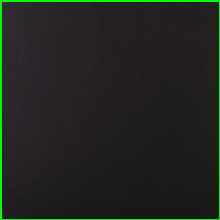


--- Menguji gambar untuk warna: blue (blue2.jpg) ---

0: 640x640 1 blue, 37.1ms
Speed: 4.3ms preprocess, 37.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Deteksi model: blue 0.99


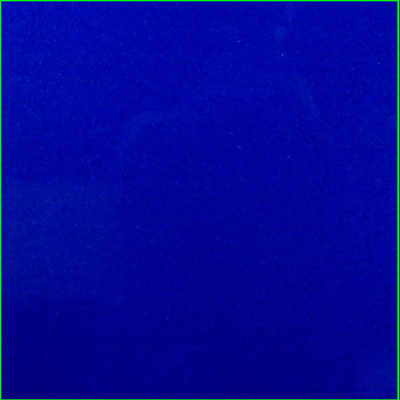


--- Menguji gambar untuk warna: brown (9f8170.png) ---

0: 640x480 1 brown, 29.7ms
Speed: 3.0ms preprocess, 29.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)
Deteksi model: brown 0.88


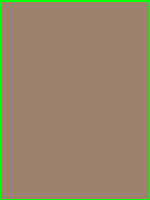


--- Menguji gambar untuk warna: green (green4.jpg) ---

0: 640x640 1 green, 36.5ms
Speed: 4.5ms preprocess, 36.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
Deteksi model: green 0.99


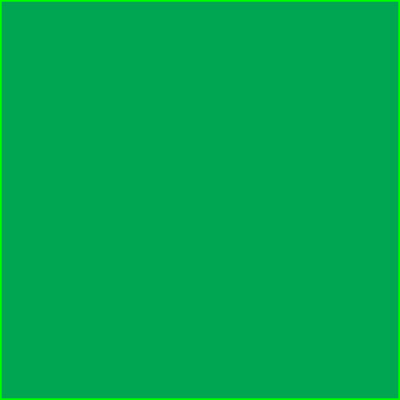


--- Menguji gambar untuk warna: grey (a8a9a8.png) ---

0: 640x480 1 grey, 20.7ms
Speed: 2.9ms preprocess, 20.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Deteksi model: grey 0.78


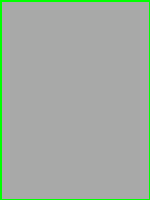


--- Menguji gambar untuk warna: orange (orange9.jpg) ---

0: 416x640 1 orange, 20.1ms
Speed: 2.9ms preprocess, 20.1ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)
Deteksi model: orange 0.79


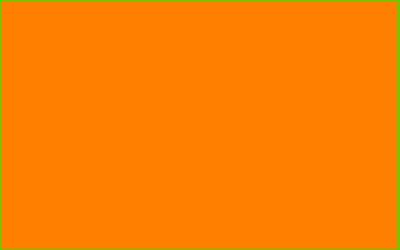


--- Menguji gambar untuk warna: red (red1.jpg) ---

0: 384x640 1 red, 18.4ms
Speed: 3.4ms preprocess, 18.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Deteksi model: red 0.91


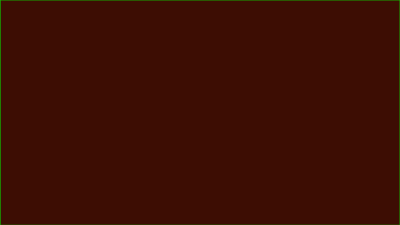


--- Menguji gambar untuk warna: violet (violet2.jpg) ---

0: 384x640 1 violet, 17.3ms
Speed: 3.1ms preprocess, 17.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Deteksi model: violet 0.99


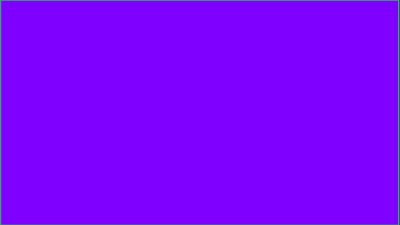


--- Menguji gambar untuk warna: white (white5.jpg) ---

0: 640x640 1 white, 26.6ms
Speed: 4.8ms preprocess, 26.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Deteksi model: white 0.85


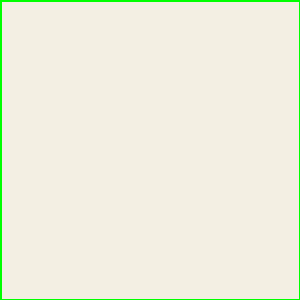


--- Menguji gambar untuk warna: yellow (yellow8.jpg) ---

0: 384x640 1 yellow, 18.4ms
Speed: 3.9ms preprocess, 18.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Deteksi model: yellow 0.93


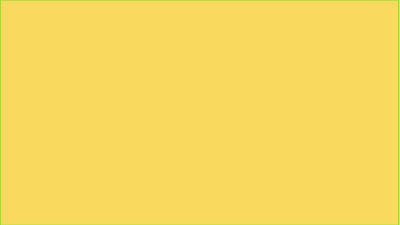

In [50]:
# 8. Tes Model dengan Gambar Contoh
# Memuat model yang telah dilatih dan melakukan deteksi pada gambar contoh.

# Temukan folder training terbaru secara otomatis
runs_dir = 'runs/detect'
latest_run = sorted([d for d in os.listdir(runs_dir) if os.path.isdir(os.path.join(runs_dir, d)) and d.startswith('train')], key=lambda x: os.path.getmtime(os.path.join(runs_dir, x)), reverse=True)

if not latest_run:
    raise FileNotFoundError("Tidak ada folder training yang ditemukan di runs/detect. Pastikan training berhasil.")

trained_model_path = os.path.join(runs_dir, latest_run[0], 'weights/best.pt')

print(f"Memuat model dari: {trained_model_path}")
model = YOLO(trained_model_path)

# Definisikan kelas-kelas warna (harus sama dengan di data.yaml)
defined_classes = ['black','blue','brown','green','grey','orange','red','violet', 'white', 'yellow']
class_to_id = {name: i for i, name in enumerate(defined_classes)}

# Path ke direktori validasi yang baru dibuat
val_images_dir = os.path.join(dataset_root, 'images', 'val') # pastikan dataset_root sudah terdefinisi dari cell sebelumnya

# Dictionary untuk menyimpan satu gambar contoh per kelas
sample_images_per_class = {}

print(f"Mencari gambar contoh dari setiap kelas di: {val_images_dir}")

# Iterasi melalui setiap kelas yang didefinisikan
for class_name in defined_classes:
    original_training_dataset_path = os.path.join(base_dataset_path, 'training_dataset') # Ulangi definisi jika tidak global
    class_folder_path = os.path.join(original_training_dataset_path, class_name)

    if os.path.exists(class_folder_path):
        images_in_class_folder = glob.glob(os.path.join(class_folder_path, '*.jpg')) + \
                                 glob.glob(os.path.join(class_folder_path, '*.jpeg')) + \
                                 glob.glob(os.path.join(class_folder_path, '*.png'))

        if images_in_class_folder:
            # Ambil satu gambar pertama dari kelas ini
            sample_images_per_class[class_name] = images_in_class_folder[0]
            print(f"  Ditemukan {class_name}: {os.path.basename(images_in_class_folder[0])}")
        else:
            print(f"  Tidak ada gambar ditemukan untuk kelas {class_name} di folder asli: {class_folder_path}")
    else:
        print(f"  Folder kelas {class_name} tidak ditemukan di: {class_folder_path}")

if not sample_images_per_class:
    print("Tidak ada gambar contoh yang ditemukan untuk diuji secara merata per kelas.")
else:
    print(f"\nMenguji {len(sample_images_per_class)} gambar contoh (satu per kelas)...")

    # Tentukan ukuran maksimal yang diinginkan untuk display (misalnya lebar 600 piksel)
    max_display_width = 400

    # Iterasi melalui gambar contoh yang telah dikumpulkan per kelas
    for class_name, img_path in sample_images_per_class.items():
        print(f"\n--- Menguji gambar untuk warna: {class_name} ({os.path.basename(img_path)}) ---")
        frame = cv2.imread(img_path)

        if frame is None:
            print(f"Gagal membaca gambar: {img_path}")
            continue

        # Lakukan deteksi
        results = model(frame)[0]

        # Gambar bounding box dan label
        detected_labels_on_image = []
        for r in results.boxes:
            x1, y1, x2, y2 = map(int, r.xyxy[0])
            label = model.names[int(r.cls[0])]
            conf = r.conf[0]
            detected_labels_on_image.append(f"{label} {conf:.2f}")
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"{label} {conf:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        if detected_labels_on_image:
            print(f"Deteksi model: {', '.join(detected_labels_on_image)}")
        else:
            print("Tidak ada objek terdeteksi.")

        # --- Bagian yang dimodifikasi untuk menyeragamkan ukuran output ---
        original_height, original_width = frame.shape[:2]

        if original_width > max_display_width:
            # Hitung rasio untuk scaling
            scale_ratio = max_display_width / float(original_width)
            new_height = int(original_height * scale_ratio)

            # Resize gambar
            resized_frame = cv2.resize(frame, (max_display_width, new_height), interpolation=cv2.INTER_AREA)
            cv2_imshow(resized_frame)
        else:
            # Jika gambar sudah kecil, tampilkan apa adanya
            cv2_imshow(frame)

Menganalisis distribusi warna yang terdeteksi...
Memulai deteksi pada 50 gambar untuk analisis distribusi...
Deteksi selesai.

Jumlah deteksi per warna:
- black: 2
- blue: 5
- brown: 8
- green: 5
- grey: 9
- orange: 2
- red: 8
- violet: 5
- white: 7
- yellow: 4


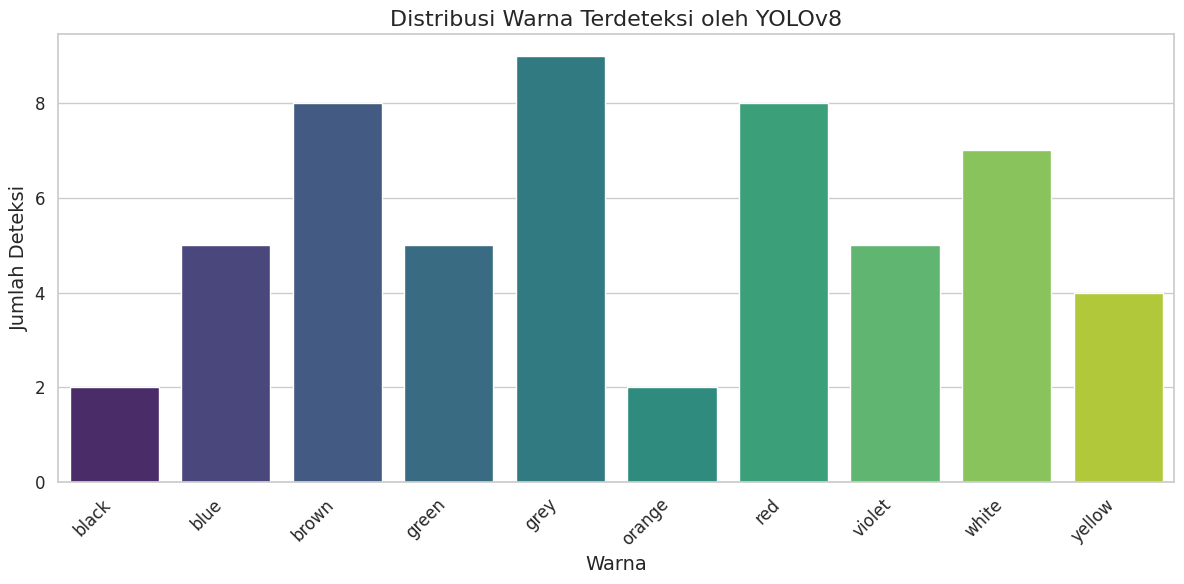

In [51]:
# 9. Visualisasi Distribusi Warna Terdeteksi
# Deteksi semua gambar di folder validasi dan hitung distribusi warna yang terdeteksi.

print("Menganalisis distribusi warna yang terdeteksi...")
# Path ke folder gambar test (gunakan set validasi yang baru dibuat)
image_dir_for_analysis = os.path.join(dataset_root, 'images', 'val')
image_paths_for_analysis = glob.glob(os.path.join(image_dir_for_analysis, '*.jpg')) + \
                           glob.glob(os.path.join(image_dir_for_analysis, '*.jpeg')) + \
                           glob.glob(os.path.join(image_dir_for_analysis, '*.png'))

# List untuk menyimpan semua label yang terdeteksi
all_detected_labels = []

print(f"Memulai deteksi pada {len(image_paths_for_analysis)} gambar untuk analisis distribusi...")

if not image_paths_for_analysis:
    print("Tidak ada gambar di set validasi untuk analisis. Melewatkan visualisasi distribusi.")
else:
    for i, image_path in enumerate(image_paths_for_analysis):
        try:
            # Prediksi pada gambar. verbose=False untuk menekan output prediksi gambar individu
            results = model.predict(image_path, verbose=False)

            # Iterasi melalui hasil deteksi untuk gambar saat ini
            for r in results:
                class_names_map = r.names

                # Iterasi melalui setiap bounding box yang terdeteksi
                for box in r.boxes:
                    cls_id = int(box.cls[0].item())
                    detected_label = class_names_map[cls_id]
                    all_detected_labels.append(detected_label)

        except Exception as e:
            print(f"Error memproses {image_path}: {e}")
            continue

    # Hitung jumlah kemunculan setiap warna yang terdeteksi
    label_counts = Counter(all_detected_labels)

    print("Deteksi selesai.\n")
    print("Jumlah deteksi per warna:")
    for label, count in sorted(label_counts.items()):
        print(f"- {label}: {count}")

    # Visualisasi Heatmap (Bar Chart)
    sns.set(style='whitegrid')
    plt.figure(figsize=(12, 6)) # Ukuran gambar sedikit lebih besar agar lebih mudah dibaca
    sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='viridis', order=sorted(label_counts.keys()))
    plt.title('Distribusi Warna Terdeteksi oleh YOLOv8', fontsize=16)
    plt.xlabel('Warna', fontsize=14)
    plt.ylabel('Jumlah Deteksi', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12) # Putar label agar lebih pas
    plt.yticks(fontsize=12)
    plt.tight_layout() # Sesuaikan tata letak untuk mencegah label tumpang tindih
    plt.show()